An attempt at multivariate

In [2]:
import pandas as pd
from pytorch_wavelets import DWT1DForward, DWT1DInverse
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers,Input,Model
import matplotlib.pyplot as plt
from tensorflow import keras

from keras.layers import LSTM
import sklearn.metrics

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from keras.layers import ConvLSTM2D, ConvLSTM1D
import tensorflow_wavelets.Layers.DWT as DWT
import tensorflow_wavelets.Layers.DTCWT as DTCWT
import tensorflow_wavelets.Layers.DMWT as DMWT
import pywt
from ReliefF import ReliefF

/Users/yash/DeepLearning/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [3]:
dfe = pd.read_csv("elec_14_22.csv",parse_dates = True, delimiter=',', header=0)
dfe['date'] = pd.to_datetime(dfe['date'], format='%Y-%m-%d')
dfe.index = dfe["date"]
del dfe['date']
del dfe['code']
del dfe['p2']
del dfe['code2']
del dfe['p3']
del dfe['p4']
del dfe['rand']
dfe.head()

,e_price
date,
2014-12-05,47.20
2014-12-08,46.56
2014-12-09,46.64
2014-12-10,46.53
2014-12-11,46.05


In [4]:
dfn = pd.read_json("natural_gas5years.json")
dfn['date'] = pd.to_datetime(dfn['date'], format='%Y-%m-%d')
dfn.rename(columns = {'y':'n_price', 'percentChange':'n_perchange'}, inplace = True)
dfn.index = dfn["date"]
del dfn['date']
del dfn['x']
del dfn['change']
dfn['n_perchange'].iloc[0] = 0
dfn.head()

,n_price,n_perchange
date,,
2017-06-14,35.19,0.000000
2017-06-15,34.33,-2.443876
2017-06-16,34.47,0.407807
2017-06-19,34.90,1.247462
2017-06-20,35.64,2.120344


In [48]:
dfn['n_price'].isnull().values.any()

False

In [5]:
dfo = pd.read_json("brent_crude_prices.json",  lines = True)
dfo.rename(columns = {'Date':'date', 'Close':'o_price'}, inplace = True)
dfo.index = dfo["date"]
del dfo['date']
del dfo['Open']
del dfo['High']
del dfo['Low']
del dfo['Volume'] # this column is just a series of 0s
del dfo['Estimate'] # this column is just a series of 0s
dfo

,o_price
date,
2017-01-16,55.86
2017-01-17,55.47
2017-01-18,53.92
2017-01-19,54.16
2017-01-20,55.49
...,...
2022-05-10,102.46
2022-05-11,107.51
2022-05-12,107.45


In [6]:
# get national demand and generation data
dfd = pd.read_csv("elecdemand_1418.csv",parse_dates = True, delimiter=',',header=0) #get data in pandas DataFrame
dfd['SETTLEMENT_DATE'] = pd.to_datetime(dfd['SETTLEMENT_DATE'], format='%d-%b-%Y') # cast the SETTLEMENT_DATE to a pandas datetime object

print("Number of data elements (number,features): ",dfd.shape) # shows number of the data elements and features available
del dfd['SETTLEMENT_PERIOD'] # delete not useful feature column
dfd = dfd.groupby('SETTLEMENT_DATE').agg('sum') # sum the rows so that there is only one entry per column
#there used to be 48 entries per day
# dfd.index = dfd["SETTLEMENT_DATE"] # set the index to SETTLEMENT_date
# del dfd['SETTLEMENT_DATE']
# Get rest of data related to demand
dfd2 = pd.read_csv("elecdemand_1922.csv",parse_dates = True, delimiter=',',header=0)
dfd2['SETTLEMENT_DATE'] = pd.to_datetime(dfd2['SETTLEMENT_DATE'], format='%d-%b-%Y') # cast the SETTLEMENT_DATE to a pandas datetime object
# delete newly added data columns
del dfd2['SETTLEMENT_PERIOD']
del dfd2['ELECLINK_FLOW']
del dfd2['NSL_FLOW']
dfd2 = dfd2.groupby('SETTLEMENT_DATE').agg('sum')
demand_data = pd.concat([dfd, dfd2],ignore_index=False) #merge the two demand DataFrames
demand_data

Number of data elements (number,features):  (87648, 17)


,ND,TSD,ENGLAND_WALES_DEMAND,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,NON_BM_STOR,PUMP_STORAGE_PUMPING,IFA_FLOW,IFA2_FLOW,BRITNED_FLOW,MOYLE_FLOW,EAST_WEST_FLOW,NEMO_FLOW
SETTLEMENT_DATE,,,,,,,,,,,,,,,
2014-01-01,1514419,1591769,1373378,61037,116832,994,160752,487,22079,92056,0,44864,-10178,-16731,0
2014-01-02,1722972,1793335,1579494,52227,116832,10388,160896,612,18871,93030,0,39935,-8824,-12983,0
2014-01-03,1756703,1828833,1606954,78808,116832,6188,161088,1429,23095,92715,0,44578,-8954,-9250,0
2014-01-04,1709434,1783278,1549245,33724,116832,1754,161232,1807,21744,93296,0,46858,-9239,-15634,0
2014-01-05,1678218,1747526,1523299,49495,116832,3319,161424,1185,22831,93640,0,47073,-9256,-6678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-17,1186845,1381936,1081231,87280,314160,111798,627840,0,9835,-34338,-49347,11,8096,10441,-45990
2022-05-18,1152270,1343249,1077576,110126,314160,120699,627840,0,14538,-34454,-39748,11,7476,0,-45304
2022-05-19,1170256,1356134,1082934,76467,314160,123370,627840,0,4825,-33186,-45515,8,8943,0,-43989


Merge the DataFrames into one large DataFrame containing all features

In [7]:
# the first 647 data elements are removed as no values for natural gas prices
merged = dfe.join(dfn).join(dfo).join(demand_data).iloc[647:]

merged

,e_price,n_price,n_perchange,o_price,ND,TSD,ENGLAND_WALES_DEMAND,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,NON_BM_STOR,PUMP_STORAGE_PUMPING,IFA_FLOW,IFA2_FLOW,BRITNED_FLOW,MOYLE_FLOW,EAST_WEST_FLOW,NEMO_FLOW
date,,,,,,,,,,,,,,,,,,,
2017-06-14,38.33,35.19,0.000000,47.00,1326531,1368412,1205063,43547,246864,127826,577200,2898,16353,69153,0,32147,4406,7988,0
2017-06-15,37.89,34.33,-2.443876,46.92,1257758,1298371,1153189,93884,246864,122070,577200,260,15287,73618,0,36819,4592,8261,0
2017-06-16,38.31,34.47,0.407807,47.37,1265627,1310241,1157498,75023,246864,102676,577200,2014,16341,59371,0,33695,-1067,3996,0
2017-06-19,38.75,34.90,1.247462,46.91,1368810,1427241,1243551,23977,246864,132616,577200,2425,22249,56518,0,46060,-1822,-3844,0
2017-06-20,40.14,35.64,2.120344,46.02,1387871,1445812,1258417,37401,246864,122254,577200,2438,23467,23654,0,43205,341,165,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-25,210.13,236.61,-10.652519,120.65,1318525,1369409,1183504,22192,314160,111544,627840,0,8595,16626,19410,45721,-8805,0,39060
2022-03-28,220.40,245.77,3.871349,112.48,1388499,1456313,1249221,14974,314160,86262,627840,0,11534,2133,-2551,38357,-13007,0,32113
2022-03-29,228.92,263.42,7.181511,110.23,1467635,1544677,1326153,28728,314160,33743,627840,0,12822,-4562,-7988,46208,-10961,0,29189


In [52]:
for col in merged.columns:
    print("No. NaN in ",col," is ",merged[col].isna().sum())

No. NaN in  e_price  is  0
No. NaN in  n_price  is  25
No. NaN in  n_perchange  is  25
No. NaN in  o_price  is  5
No. NaN in  ND  is  0
No. NaN in  TSD  is  0
No. NaN in  ENGLAND_WALES_DEMAND  is  0
No. NaN in  EMBEDDED_WIND_GENERATION  is  0
No. NaN in  EMBEDDED_WIND_CAPACITY  is  0
No. NaN in  EMBEDDED_SOLAR_GENERATION  is  0
No. NaN in  EMBEDDED_SOLAR_CAPACITY  is  0
No. NaN in  NON_BM_STOR  is  0
No. NaN in  PUMP_STORAGE_PUMPING  is  0
No. NaN in  IFA_FLOW  is  0
No. NaN in  IFA2_FLOW  is  0
No. NaN in  BRITNED_FLOW  is  0
No. NaN in  MOYLE_FLOW  is  0
No. NaN in  EAST_WEST_FLOW  is  0
No. NaN in  NEMO_FLOW  is  0


There are only 3 columns with NaN values.

In [8]:
#get the indices of the natural gas prices which are NaN
ng_ind = merged['n_price'].isna()
ng_ind = ng_ind[ng_ind].index
for index in ng_ind:
    loc = merged.index.get_loc(index)
    change = (merged['e_price'][loc] - merged['e_price'][loc-1])/merged['e_price'][loc-1]
    merged.at[index,'n_perchange'] = change*100
    merged.at[index,'n_price'] = merged['n_price'][loc-1] * (1+change)
#merged['e_price'][ng_ind] - merged['e_price'][ng_ind-1]
merged.loc[ng_ind[13]]

e_price                      4.191000e+01
n_price                      3.261517e+01
n_perchange                 -2.056555e+00
o_price                      6.477000e+01
ND                           1.321105e+06
TSD                          1.404783e+06
ENGLAND_WALES_DEMAND         1.205775e+06
EMBEDDED_WIND_GENERATION     8.705100e+04
EMBEDDED_WIND_CAPACITY       2.967360e+05
EMBEDDED_SOLAR_GENERATION    5.951300e+04
EMBEDDED_SOLAR_CAPACITY      6.278400e+05
NON_BM_STOR                  0.000000e+00
PUMP_STORAGE_PUMPING         1.116000e+04
IFA_FLOW                    -8.418000e+03
IFA2_FLOW                    0.000000e+00
BRITNED_FLOW                -4.080000e+03
MOYLE_FLOW                  -6.101000e+03
EAST_WEST_FLOW               4.460000e+02
NEMO_FLOW                    6.818000e+03
Name: 2019-09-23 00:00:00, dtype: float64

In [9]:
o_ind = merged['o_price'].isna()
o_ind = o_ind[o_ind].index
for index in o_ind[:2]:#for the first two NaN oil prices, they are set as the average of the preceding and succeding values
    loc = merged.index.get_loc(index)
    merged.at[index,'o_price'] = (merged['o_price'][loc+1] + merged['o_price'][loc-1])/2
#the last three NaN oil prices are consecutive
loc = merged.index.get_loc(o_ind[2])-1 #they are set as the first preceding non-NaN price
for index in o_ind[2:]:
    merged.at[index,'o_price'] = merged['o_price'][loc]

In [10]:
for col in merged.columns:
    print("No. NaN in ",col," is ",merged[col].isna().sum())

No. NaN in  e_price  is  0
No. NaN in  n_price  is  0
No. NaN in  n_perchange  is  0
No. NaN in  o_price  is  0
No. NaN in  ND  is  0
No. NaN in  TSD  is  0
No. NaN in  ENGLAND_WALES_DEMAND  is  0
No. NaN in  EMBEDDED_WIND_GENERATION  is  0
No. NaN in  EMBEDDED_WIND_CAPACITY  is  0
No. NaN in  EMBEDDED_SOLAR_GENERATION  is  0
No. NaN in  EMBEDDED_SOLAR_CAPACITY  is  0
No. NaN in  NON_BM_STOR  is  0
No. NaN in  PUMP_STORAGE_PUMPING  is  0
No. NaN in  IFA_FLOW  is  0
No. NaN in  IFA2_FLOW  is  0
No. NaN in  BRITNED_FLOW  is  0
No. NaN in  MOYLE_FLOW  is  0
No. NaN in  EAST_WEST_FLOW  is  0
No. NaN in  NEMO_FLOW  is  0


In [56]:
merged

,e_price,n_price,n_perchange,o_price,ND,TSD,ENGLAND_WALES_DEMAND,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,NON_BM_STOR,PUMP_STORAGE_PUMPING,IFA_FLOW,IFA2_FLOW,BRITNED_FLOW,MOYLE_FLOW,EAST_WEST_FLOW,NEMO_FLOW
date,,,,,,,,,,,,,,,,,,,
2017-06-14,38.33,35.19,0.000000,47.00,1326531,1368412,1205063,43547,246864,127826,577200,2898,16353,69153,0,32147,4406,7988,0
2017-06-15,37.89,34.33,-2.443876,46.92,1257758,1298371,1153189,93884,246864,122070,577200,260,15287,73618,0,36819,4592,8261,0
2017-06-16,38.31,34.47,0.407807,47.37,1265627,1310241,1157498,75023,246864,102676,577200,2014,16341,59371,0,33695,-1067,3996,0
2017-06-19,38.75,34.90,1.247462,46.91,1368810,1427241,1243551,23977,246864,132616,577200,2425,22249,56518,0,46060,-1822,-3844,0
2017-06-20,40.14,35.64,2.120344,46.02,1387871,1445812,1258417,37401,246864,122254,577200,2438,23467,23654,0,43205,341,165,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-10,164.40,145.77,13.254603,102.46,1128077,1347482,1051718,144812,314160,101636,627840,0,10183,-47587,-49344,-40287,7346,2723,-33548
2022-05-11,164.55,139.74,-4.136654,107.51,1203077,1402227,1121578,129520,314160,67429,627840,0,9790,-33529,-47844,-22534,-3202,-825,-20442
2022-05-12,193.04,175.55,25.626163,107.45,1167199,1388602,1081480,113021,314160,104265,627840,0,6010,-47273,-48635,-32285,4338,2215,-46641


In [11]:
normalized_df=(merged-merged.min())/(merged.max()-merged.min())

del normalized_df['TSD']
del normalized_df['n_perchange']
normalized_df.head()

,e_price,n_price,o_price,ND,ENGLAND_WALES_DEMAND,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,NON_BM_STOR,PUMP_STORAGE_PUMPING,IFA_FLOW,IFA2_FLOW,BRITNED_FLOW,MOYLE_FLOW,EAST_WEST_FLOW,NEMO_FLOW
date,,,,,,,,,,,,,,,,,
2017-06-14,0.027266,0.050547,0.254671,0.396045,0.373247,0.129633,0.012428,0.783663,0.0,0.388472,0.634562,0.861032,0.50074,0.771272,0.655745,0.672871,0.418201
2017-06-15,0.026428,0.048928,0.253935,0.330057,0.318922,0.347370,0.012428,0.747784,0.0,0.034853,0.592136,0.884176,0.50074,0.829577,0.660390,0.678383,0.418201
2017-06-16,0.027228,0.049191,0.258076,0.337608,0.323435,0.265785,0.012428,0.626893,0.0,0.269973,0.634084,0.810327,0.50074,0.790590,0.519067,0.592280,0.418201
2017-06-19,0.028065,0.050001,0.253843,0.436612,0.413553,0.044982,0.012428,0.813521,0.0,0.325067,0.869219,0.795539,0.50074,0.944902,0.500212,0.434005,0.418201
2017-06-20,0.030710,0.051394,0.245651,0.454901,0.429122,0.103048,0.012428,0.748931,0.0,0.326810,0.917695,0.625190,0.50074,0.909272,0.554229,0.514939,0.418201


In [12]:
dataset_size = len(normalized_df)
trainset_size = int(dataset_size*0.8)
valset_size = int(dataset_size*0.1)
testset_size = dataset_size - trainset_size

In [59]:
normalized_df.iloc[:-1,1:].values

array([[0.05054689, 0.25467096, 0.3960453 , ..., 0.65574507, 0.67287116,
        0.49199367],
       [0.04892788, 0.25393465, 0.33005726, ..., 0.66039008, 0.67838253,
        0.49199367],
       [0.04919144, 0.25807639, 0.33760761, ..., 0.519067  , 0.59228005,
        0.49199367],
       ...,
       [0.24736911, 0.81159687, 0.27759057, ..., 0.46574932, 0.49495296,
        0.27636076],
       [0.31478379, 0.81104464, 0.24316545, ..., 0.6540469 , 0.55632495,
        0.        ],
       [0.26376626, 0.84878049, 0.1545494 , ..., 0.67687236, 0.66903541,
        0.18565401]])

In [13]:
relief = ReliefF(n_features_to_keep=10)

relief.fit(normalized_df.iloc[:-1,1:].values,normalized_df.iloc[1:,0].values)

In [14]:
normalized_df.columns

Index(['e_price', 'n_price', 'o_price', 'ND', 'ENGLAND_WALES_DEMAND',
       'EMBEDDED_WIND_GENERATION', 'EMBEDDED_WIND_CAPACITY',
       'EMBEDDED_SOLAR_GENERATION', 'EMBEDDED_SOLAR_CAPACITY', 'NON_BM_STOR',
       'PUMP_STORAGE_PUMPING', 'IFA_FLOW', 'IFA2_FLOW', 'BRITNED_FLOW',
       'MOYLE_FLOW', 'EAST_WEST_FLOW', 'NEMO_FLOW'],
      dtype='object')

In [15]:
relief.feature_scores

array([123530., 123508., 123666., 123662., 123664.,  16540., 123660.,
       -87768., -43380., 123644., 122874., -42900., 121416., 123566.,
       122598.,  45792.])

In [16]:
normalized_df.columns[relief.top_features+1]

Index(['ND', 'EMBEDDED_WIND_GENERATION', 'ENGLAND_WALES_DEMAND',
       'EMBEDDED_SOLAR_GENERATION', 'PUMP_STORAGE_PUMPING', 'MOYLE_FLOW',
       'n_price', 'o_price', 'IFA_FLOW', 'EAST_WEST_FLOW', 'BRITNED_FLOW',
       'NEMO_FLOW', 'EMBEDDED_WIND_CAPACITY', 'IFA2_FLOW', 'NON_BM_STOR',
       'EMBEDDED_SOLAR_CAPACITY'],
      dtype='object')

In [17]:
from keras.layers.core import Dense, Activation
import tensorflow as tf


from keras.layers.convolutional import Convolution1D
def ufcnn_model_concat(sequence_length=5000,
                       features=1,
                       nb_filter=150,
                       filter_length=5,
                       optimizer='adam',
                       activation="softplus",
                       init="lecun_uniform",
                       wavelet = False):

    inputs = keras.Input(shape=(None, features))

    inputs = tf.keras.layers.LayerNormalization(axis=-1)(inputs)
    start = Convolution1D(filters=nb_filter, kernel_size=filter_length,activation=activation, padding='valid', kernel_initializer=init, input_shape=(1,sequence_length, features),name='conv1')(inputs)
    start2 = Convolution1D(filters=nb_filter, kernel_size=filter_length,activation=activation, padding='same', kernel_initializer=init, name='conv2')(start)
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length,activation=activation, padding='same', kernel_initializer=init, name='conv3')(start2)
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length,activation=activation, padding='same', kernel_initializer=init, name='conv4')(x)
    x = tf.keras.layers.concatenate([start2, x], axis=-1)
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length,activation=activation, padding='same', kernel_initializer=init, name='conv5')(x)
    x = tf.keras.layers.concatenate([start, x], axis=-1)
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length,activation=activation, padding='same', kernel_initializer=init, name='conv6')(x)
    x = Convolution1D(filters=nb_filter, kernel_size=filter_length, padding='same', kernel_initializer=init, name='conv7')(x)

    x = LSTM(128)(tf.reshape(x, shape=(1,6,nb_filter)))
    x = Activation('relu', name='relu7')(x)

    x = Dense(1)(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(optimizer=optimizer, loss='mse', run_eagerly=True)
    model.summary()
    return model

In [22]:
features = relief.top_features[:4]+1
data = normalized_df.iloc[:,features]
data

,ND,EMBEDDED_WIND_GENERATION,ENGLAND_WALES_DEMAND,EMBEDDED_SOLAR_GENERATION
date,,,,
2017-06-14,0.396045,0.129633,0.373247,0.783663
2017-06-15,0.330057,0.347370,0.318922,0.747784
2017-06-16,0.337608,0.265785,0.323435,0.626893
2017-06-19,0.436612,0.044982,0.413553,0.813521
2017-06-20,0.454901,0.103048,0.429122,0.748931
...,...,...,...,...
2022-03-25,0.388364,0.037261,0.350669,0.682171
2022-03-28,0.455504,0.006039,0.419491,0.524578
2022-03-29,0.531435,0.065533,0.500058,0.197206


In [25]:
window_size=10
#noisy_data = fn_addnoise(elecs_norm,trainset_size-valset_size)
#log_data = np.log(elecs_norm+1)
batches=1
num_features = 5
# wavelet = DWT1DForward()
# inputs = pd.DataFrame(wavelet(np.expand_dims(normalized_df[['e_price','ND']].values,axis=0)))
features = relief.top_features[:num_features]+1
features[4] = 0
data = normalized_df.iloc[:,features]
days_ahead = 5
dataset = keras.utils.timeseries_dataset_from_array(
        data=data.iloc[:-days_ahead,:],
        targets=normalized_df.iloc[window_size+days_ahead:,0],
        sequence_length=window_size,
        batch_size=batches,
    )
testset_size=150
trainset_size = len(normalized_df) - window_size - days_ahead - testset_size
# for item, target in dataset.take(1):
#     print(item.shape)
#     print(target.shape)
# dataset = keras.utils.timeseries_dataset_from_array(
#         data=input,
#         targets=input.iloc[window_size:,0],
#         sequence_length=window_size,
#         batch_size=batches
#     )
# --- Define training, validation and testing datasets
# X_train = dataset.take(trainset_size-window_size)
# X_val =dataset.skip(trainset_size-valset_size-window_size).take(valset_size)
# X_test = dataset.skip(trainset_size-window_size).take(testset_size)
# #print(inputs)

offset = 500
X_train = dataset.skip(offset).take(trainset_size-offset)
#X_val =dataset.skip(trainset_size-valset_size-window_size).take(valset_size)
X_test = dataset.skip(trainset_size).take(testset_size)
# for item, target in X_train.take(1):
#     print(item.shape)
#     print(target.shape)
tf.config.run_functions_eagerly(True)
model = ufcnn_model_concat(10,num_features)

hist_wa = model.fit(X_train,epochs=10,validation_data=X_test, batch_size=batches, verbose=1, shuffle=False, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])

/Users/yash/DeepLearning/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/yash/DeepLearning/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/yash/DeepLearning/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager exe

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, 5)]    0           []                               
                                                                                                  
 conv1 (Conv1D)                 (None, None, 150)    3900        ['input_4[0][0]']                
                                                                                                  
 relu1 (Activation)             (None, None, 150)    0           ['conv1[1][0]']                  
                                                                                                  
 conv2 (Conv1D)                 (None, None, 150)    112650      ['relu1[1][0]']                  
                                                                                            

In [67]:
def calc_r2(prediction,real,obs_size):
    """
    :param prediction: The forecasted time series
    :param real: The expected time series composed of real observations
    :param obs_size: The window size of
    :return: floating point r2 score <=1
    """
    lstm_diff = prediction.values.reshape(-1,1) - real.iloc[:-1].values.reshape(-1,1)
    #mask = np.all(np.isnan(lstm_diff),axis=1)
    #lstm_diff = lstm_diff[~mask].reshape(-1,1)
    temp_diff = real.iloc[1:].values.reshape(-1,1) - real.iloc[:-1].values.reshape(-1,1)
    #mask = np.all(np.isnan(temp_diff),axis=1)
    #temp_diff = temp_diff[~mask].reshape(-1,1)
    return sklearn.metrics.r2_score(temp_diff.reshape(-1,1), lstm_diff.reshape(-1,1))

150/150 [==============================] - 4s 23ms/step


ValueError: Found input variables with inconsistent numbers of samples: [150, 165]

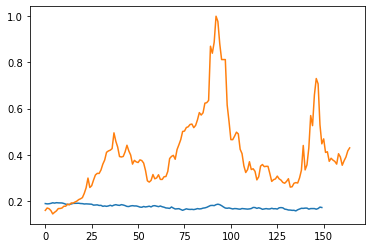

In [26]:
f = (model.predict(X_test))

plt.plot(f)
plt.plot(normalized_df['e_price'][trainset_size:].values)
#calc_r2(pd.Series(f.ravel()),normalized_df['e_price'][trainset_size-1:],0)
sklearn.metrics.r2_score(f,normalized_df['e_price'][trainset_size:])

In [82]:
train_num = 50
forecast = []
for i in np.arange(0,testset_size-100,1):
    model = ufcnn_model_concat(10,num_features)
    X_train = dataset.skip(trainset_size-train_num+i).take(train_num)
    X_test = dataset.skip(trainset_size+i).take(1)
    hist_wa = model.fit(X_train,epochs=2,validation_data=X_test, batch_size=batches, verbose=1, shuffle=False, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])
    forecast.append(model.predict(X_test))

Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, None, 4)]    0           []                               
                                                                                                  
 conv1 (Conv1D)                 (None, None, 150)    3150        ['input_33[0][0]']               
                                                                                                  
 relu1 (Activation)             (None, None, 150)    0           ['conv1[0][0]']                  
                                                                                                  
 conv2 (Conv1D)                 (None, None, 150)    112650      ['relu1[0][0]']                  
                                                                                           

0.9333591464545753

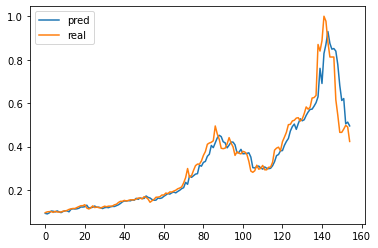

In [119]:
plt.plot(np.array(forecast).ravel(),label="pred")
plt.plot(normalized_df['e_price'][trainset_size+10:-90].values,label="real")
plt.legend()
#calc_r2(pd.Series(f.ravel()),normalized_df['e_price'][trainset_size-1:],0)
sklearn.metrics.r2_score(np.array(forecast).ravel(),normalized_df['e_price'][trainset_size+10:-90])

In [168]:
%store forecast

Stored 'forecast' (list)


In [107]:
train_num = 50
simple_forecast = np.zeros((100,50))
for i in np.arange(0,100,1):
    simple_model = tf.keras.Sequential([
        LSTM(128,activation='relu',return_sequences=True),
        LSTM(64,activation='relu'),
        Dense(1)
    ])
    simple_model.compile(optimizer='adam', loss='mse', run_eagerly=True)
    X_train = dataset.skip(trainset_size-50+i).take(50)
    X_test = dataset.skip(trainset_size+i).take(50)
    hist_wa = simple_model.fit(X_train,epochs=2,validation_data=X_test, batch_size=batches, verbose=1, shuffle=False, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])
    simple_forecast[i,:] = simple_model.predict(X_test).reshape((-1,))


Epoch 1/2
50/50 [==============================] - 6s 107ms/step - loss: 1.1504e-04 - val_loss: 0.0022
Epoch 2/2
50/50 [==============================] - 5s 103ms/step - loss: 5.5884e-05 - val_loss: 0.0026
Epoch 1/2
50/50 [==============================] - 5s 104ms/step - loss: 7.4370e-05 - val_loss: 0.0016
Epoch 2/2
50/50 [==============================] - 5s 105ms/step - loss: 4.5389e-04 - val_loss: 0.0022
Epoch 1/2
50/50 [==============================] - 6s 107ms/step - loss: 1.5375e-04 - val_loss: 0.0017
Epoch 2/2
50/50 [==============================] - 5s 104ms/step - loss: 3.9369e-04 - val_loss: 0.0026
Epoch 1/2
50/50 [==============================] - 6s 112ms/step - loss: 2.7176e-04 - val_loss: 0.0021
Epoch 2/2
50/50 [==============================] - 5s 108ms/step - loss: 8.1758e-05 - val_loss: 0.0023
Epoch 1/2
50/50 [==============================] - 5s 101ms/step - loss: 2.4043e-04 - val_loss: 0.0027
Epoch 2/2
50/50 [==============================] - 5s 100ms/step - loss: 

0.9255110885147108
0.0011977377690242739


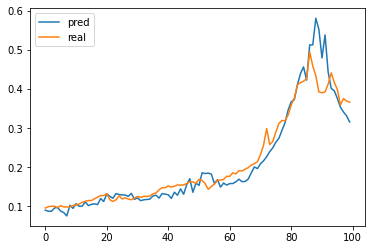

In [139]:
plt.plot(simple_forecast[:,0],label="pred")
plt.plot(normalized_df['e_price'][trainset_size+10:trainset_size+110].values,label="real")
plt.legend()
#calc_r2(pd.Series(f.ravel()),normalized_df['e_price'][trainset_size-1:],0)
print(sklearn.metrics.r2_score(simple_forecast[:,0],normalized_df['e_price'][trainset_size+10:trainset_size+110]))
(print(sklearn.metrics.mean_squared_error(simple_forecast[:,0],normalized_df['e_price'][trainset_size+10:trainset_size+110].values)))

In [169]:
%store simple_forecast

Stored 'simple_forecast' (ndarray)


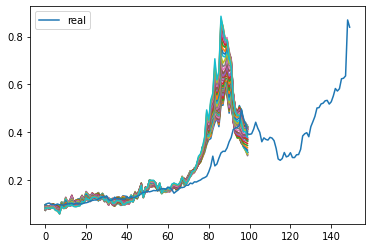

In [113]:
plt.plot(simple_forecast[:,:])
plt.plot(normalized_df['e_price'][trainset_size:trainset_size+150].values,label="real")
plt.legend()

In [128]:
window_size=10
dataset = keras.utils.timeseries_dataset_from_array(
        data=normalized_df.iloc[:-1,0],
        targets=normalized_df.iloc[window_size:,0],
        sequence_length=window_size,
        batch_size=1,
    )
X_test = dataset.skip(trainset_size-window_size).take(testset_size)
train_num=50
ufcn_forecast = np.zeros((testset_size,testset_size))
for i in np.arange(0,testset_size,1):
    model = ufcnn_model_concat(10,1)
    X_train = dataset.skip(trainset_size-window_size-train_num+i).take(train_num)
    hist_wa = model.fit(X_train,epochs=2,validation_data=X_test, batch_size=batches, verbose=1, shuffle=False, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])
    ufcn_forecast[i, :] = (model.predict(X_test)).reshape((-1,))

/Users/yash/DeepLearning/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/yash/DeepLearning/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/yash/DeepLearning/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager exe

Model: "model_190"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_191 (InputLayer)         [(None, None, 1)]    0           []                               
                                                                                                  
 conv1 (Conv1D)                 (None, None, 150)    900         ['input_191[0][0]']              
                                                                                                  
 relu1 (Activation)             (None, None, 150)    0           ['conv1[0][0]']                  
                                                                                                  
 conv2 (Conv1D)                 (None, None, 150)    112650      ['relu1[0][0]']                  
                                                                                          

0.8682121142102649
0.003576647062562196
0.08532062448744886


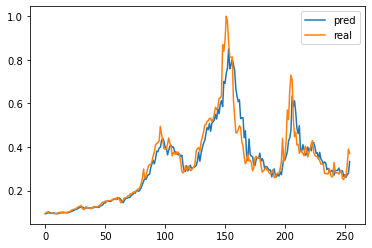

In [146]:
plt.plot(ufcn_forecast[:,0],label = "pred")
plt.plot(normalized_df['e_price'][trainset_size:].values, label = "real")
plt.legend()
print(sklearn.metrics.r2_score(ufcn_forecast[:,0],normalized_df['e_price'][trainset_size:].values))
print(sklearn.metrics.mean_squared_error(ufcn_forecast[:,0],normalized_df['e_price'][trainset_size:].values))
print(sklearn.metrics.mean_absolute_percentage_error(ufcn_forecast[:,0],normalized_df['e_price'][trainset_size:].values))

In [170]:
%store ufcn_forecast

Stored 'ufcn_forecast' (ndarray)


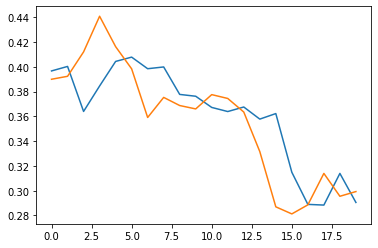

In [144]:
plt.plot(ufcn_forecast[100:120,0],label = "pred")
plt.plot(normalized_df['e_price'][trainset_size+100:trainset_size+120].values, label = "real")

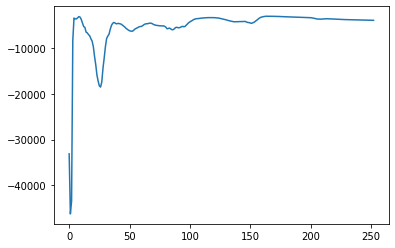

In [149]:
from sklearn.metrics import r2_score
r2s = []
for i in range(2,ufcn_forecast.shape[1]):
    r2s.append(r2_score(ufcn_forecast[0,:i], normalized_df['e_price'][trainset_size:trainset_size+i].values))
plt.plot(r2s)

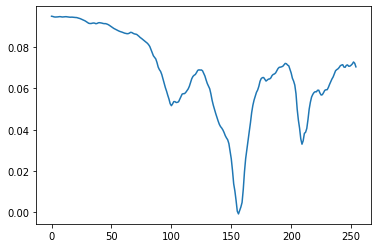

In [153]:
plt.plot(ufcn_forecast[1,:])

In [176]:
tf.random.set_seed(1234)
window_size=10
dataset = keras.utils.timeseries_dataset_from_array(
        data=normalized_df.iloc[-101:-1,0],
        targets=normalized_df.iloc[-101+window_size:,0],
        sequence_length=window_size,
        batch_size=1,
    )
X_train = dataset.skip(trainset_size-window_size-50).take(50)
model = ufcnn_model_concat(10,1)
model.fit(X_train,epochs=15,validation_data=X_test, batch_size=batches, verbose=1, shuffle=False, callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)])
u2_pred = model.predict(X_test)

Model: "model_448"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_451 (InputLayer)         [(None, None, 1)]    0           []                               
                                                                                                  
 conv1 (Conv1D)                 (None, None, 150)    900         ['input_451[0][0]']              
                                                                                                  
 relu1 (Activation)             (None, None, 150)    0           ['conv1[1][0]']                  
                                                                                                  
 conv2 (Conv1D)                 (None, None, 150)    112650      ['relu1[1][0]']                  
                                                                                          

-3031.6845515157675
0.08688752034999257
2.846596341492729


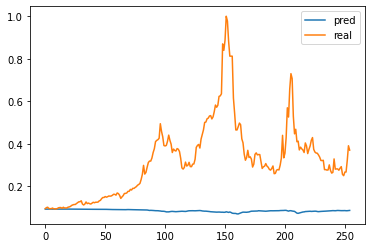

In [177]:
plt.plot(u2_pred,label = "pred")
plt.plot(normalized_df['e_price'][trainset_size:].values, label = "real")
plt.legend()
print(sklearn.metrics.r2_score(u2_pred,normalized_df['e_price'][trainset_size:].values))
print(sklearn.metrics.mean_squared_error(u2_pred,normalized_df['e_price'][trainset_size:].values))
print(sklearn.metrics.mean_absolute_percentage_error(u2_pred,normalized_df['e_price'][trainset_size:].values))

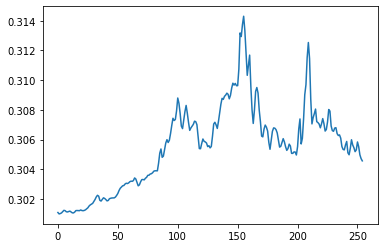

In [164]:
plt.plot(u2_pred)

0.05286326143778969

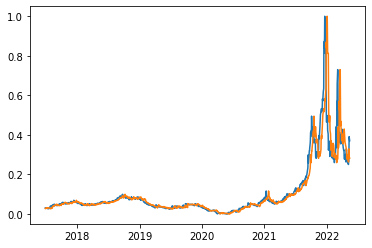

In [147]:
plt.plot(normalized_df['e_price'][10:])
plt.plot(normalized_df['e_price'].shift(10)[10:])
sklearn.metrics.mean_absolute_percentage_error(normalized_df['e_price'][trainset_size:],normalized_df['e_price'].shift(1)[trainset_size:])

Attempt at transfer learning

In [ ]:
dataset = keras.utils.timeseries_dataset_from_array(
        data=normalized_df.iloc[:-1,0],
        targets=normalized_df.iloc[window_size:,0],
        sequence_length=window_size,
        batch_size=1,
)
X_train = dataset.take(trainset_size)
X_test = dataset.skip(trainset_size-window_size).take(testset_size)
base_model = tf.keras.applications.ResNet152(weights = 'imagenet', include_top = False, input_shape = (32,32,3))
for layer in base_model.layers:
  layer.trainable = False
x = layers.Flatten()(base_model.output)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(10, activation = 'softmax')(x)


head_model = Model(inputs = base_model.input, outputs = predictions)
head_model.compile(optimizer='adam', loss='mse', metrics=['mape'])
history = head_model.fit(X_train, batch_size=64, epochs=40, validation_data=X_test)